# 3.2 Overlap in Lexical and Literary Vocabulary: Digging Deeper

In order to research the relationship between lexical and literary material in more detail we first organize the [epsd2/literary](http://oracc.org/epsd2/literary) corpus in a Document Term Matrix. A Document Term Matrix is a table in which each row is a document (in our case: a literary composition) and each column represents a lemma. Each cell indicates how many times the lemma appears in this particular document.

### 3.2.0 Preparation

First import the necessary libraries. If you are running this notebook in Jupyter Lab you will need to install the Jupyter Lab ipywidgets extension (see [Introduction](../1_Preliminaries/1_Introduction.md), section 1.2.2.1). 

The [LexicalRichness](https://pypi.org/project/lexicalrichness/) package by Lucas Shen has been adapted for the present purposes in order to circumvent preprocessing and tokenization. The adapted version, named `lexicalrichness_v` can be imported from the `utils` directory. The usage information in the [LexicalRichness](https://pypi.org/project/lexicalrichness/) website is valid for `lexicalrichness_v` with the following exceptions:
- the option use_TextBlob in LexicalRichness() is removed
- the option use_tokenizer in LexicalRichness is added; default is use_tokenizer = False.

If `use_tokenizer = False` (default) the function expects a list as input; no tokenizing or preprocessing is performed. If `use_tokenizer = True` the function expects a string, which is preprocessed and tokenized (default behaviour in the original package).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
import pandas as pd
from ipywidgets import interact
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import MWETokenizer
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import zipfile
import json
from tqdm.auto import tqdm
tqdm.pandas() # initiate pandas support in tqdm, allowing progress_apply() and progress_map()
import os
import sys
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from lexicalrichness_v import LexicalRichness as lr

Open the files `litlines.p` and `lexlines.p` which were produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). These files contain the pickled versions of the DataFrames `lit_lines` and `lex_lines` in which the literary ([epsd2/literary](http://oracc.org/epsd2/literary)) and lexical corpora ([DCCLT](http://oracc.org/dcclt)) are represented in line-by-line format.

In [2]:
lit_lines = pd.read_pickle('output/litlines.p')
lex_lines = pd.read_pickle('output/lexlines.p')

Remove unlemmatized words from the column `lemma_mwe`. Each entry in `lemma_mwe` is a list of lemmatized words and expressions.

In [3]:
lit_lines['lemma_mwe'] = lit_lines.progress_apply(lambda x: [lemma for lemma in x['lemma_mwe'] 
                                if not '[na]' in lemma],
                                axis = 1)

#### 3.2.0.1 Literary: By Composition
For the literary corpus we can take the line-by-line representation that was prepared in the previous notebook and transform that into a composition-by-composition representation. The DataFrame `etcsl_lines` includes the column `lemma_mwe` in which each line is represented as a list of lemmas and/or Multiple Word Expressions (lemmas connected by underscores). The `pandas` `groupby()` function is used to group on `id_text` and `text_name`. The aggregate function for the `lemma_mwe` column in this case is simply `sum`: all the lists (representing lines) are added up to form one long list of lemmas representing one composition.

In [4]:
lit_comp = lit_lines.groupby(
    [lit_lines["id_text"]]).aggregate(
    {"lemma_mwe": sum}).reset_index()
lit_comp['id_text'] = [id[-7:] for id in lit_comp["id_text"]]
lit_comp[25:35]

,id_text,lemma_mwe
25,P254863,"[iri[city]n, silim[healthy]v/i, tag[touch]v/t,..."
26,P254864,"[kugzu[wise]aj, namkugzu[wisdom]n, u[and]cnj, ..."
27,P254865,"[lu[person]n_niŋgina[truth]n, zi[life]n, utud[..."
28,P254866,"[niŋ[thing]n_gu[neck]n_ŋar[place]v/t, niŋ[thin..."
29,P254867,"[dubsar[scribe]n, mu[name]n, igi[eye]n, ni[sel..."
30,P254868,"[mu[name]n, diš[one]nu, zu[know]v/t, sag[good]..."
31,P254869,"[dubsar[scribe]n, emegir[sumerian]n, inim[word..."
32,P254870,"[dubsar[scribe]n_tur[small]v/i, bar[outside]n,..."
33,P254871,"[šah[pig]n, šu[hand]n, kar[flee]v/i, iginzu[as..."
34,P254872,"[amaʾatud[slave]n, sulum[contempt]n, er[tears]..."


The result is a DataFrame with two columns: `id_text`, and `lemma_mwe`. Each row represents a literary composition from the [epsd2/literary](http://oracc.org/epsd2/literary) corpus. Each cell in the column `lemma_mwe` contains a list with all the lemmas of one composition (with MWEs connected by underscores).

#### 3.2.0.2 Lexical: Extract Vocabulary
The column `lemma` in the DataFrame `lex_lines`, which was created in the last notebook represents each line in each Old Babylonian lexical text as a tuple of lemmas. Thus, the line **udu niga** in the [Old Babylonian list of Animals](http://oracc.org/dcclt/Q000001) is represented as `(udu[sheep], niga[fattened])`. In order to get the fullest representation of the lexical vocabulary, we will create the entry `udu[sheep]_niga[fattened]` (the Multiple Word Expression) as well as the entries `udu[sheep]` and `niga[fattened]` (the individual lemmas).

First, a column `lemma_mwe` is added to the `lex_lines` DataFrame, connecting all lemmas in a lexical entry by an underscore, crreating the Multiple Word Expressions. All duplicate entries are removed by creating a set (`lex_vocab_a`) that excludes MWEs which contain unlemmatized components.

A second set extracts each individual lemma from `lex_lines['lemma']`, and also excludes non-lemmatized entries.

The union of these two sets will have all individual lemmas, as well as all Multiple Word Entries. This set is turned into a list for use in `CountVectorizer()`.

In [5]:
lex_lines["lemma_mwe"] = ["_".join(entry) for entry in lex_lines["lemma"]]
lex_vocab_a = {lemma for lemma in lex_lines["lemma_mwe"] if not '[na]' in lemma}
lex_vocab_b = {item for t in lex_lines['lemma'] for item in t if not '[na]' in item} 
lex_vocab = lex_vocab_a.union(lex_vocab_b)
lex_vocab = list(lex_vocab) # lex_vocab is needed for Countvectorizer
lex_vocab.sort()
lex_vocab[:10]

['a[arm]n',
 'a[arm]n_ak[do]v/t',
 'a[arm]n_apin[plow]n',
 'a[arm]n_bad[open]v/t',
 'a[arm]n_bad[wall]n',
 'a[arm]n_badsi[parapet]n',
 'a[arm]n_be[diminish]v/t',
 'a[arm]n_da[line]n',
 'a[arm]n_dabašin[object]n',
 'a[arm]n_daluš[sling]n']

# Some thoughts

* Step 1. Measure length of lemma_mwe in etcsl_comp and remove rows with len < 200.
* Step 2. Create DTM (see below) of etcsl_comp, binary = True and vocabulary = lemma_mwe from lex (use lex_lines)
* Step 3. Order compositions by highest match
* Step 4. Normalize for text length (from Step 1)
* Step 5. Same process for individual lex texts (which has highest match for Ura 4?)
* Step 6. TF-IDF

In future iteration: do *not* select among lexical texts - let the script figure out which lex compositions are most relevant.

Perhaps: make DTM first - show that DTM.shape gives same numbers for lex vocabulary as second Venn diagram above. Remove all columns where sum == 0. Show that DTM.shape now gives total of overlap as in Venn diagram above. Then remove rows <= minimum. Tricky!

### 3.2.1 Basic Statistics of the [epsd2/literary](http://oracc.org/epsd2/literary) Corpus
In computing the relationship between lexical and literary vocabulary text length is playing a big role. A long text will likely have more overlap with lexical vocabulary than a very short one. The [epsd2/literary](http://oracc.org/epsd2/literary) corpus includes compositions that are known only from a fragmentary *incipit*, as well as compositions that are more than a thousand lines long.

In order to meaningfully compare these compositions we will first eliminate all texts that have fewer than 200 lemmas and/or MWEs. Second, we will collect data on text length and lexical variation (how many unique lemmas are used in this text?). Dividing lexical variation by text length provides the "Type to Token Ratio" or TTR. 

TTR is generally considered to be a poor measurement for lexical richness. Short texts have higher TTR values than long texts, because longer texts will by necessity use the same words over and over again and function words such as "the" or "in" will be repeated many times whatever the lexical ingenuity of the author. A better measurement is called MTLD or Measure of Textual Lexical Diversity ([McCarthy and Jarvis 2010](https://link.springer.com/article/10.3758/BRM.42.2.381)). The MTLD value is calculated as the mean number of words in a text that will bring TTR from 1 (at the first word in the text) down to a threshold value (default is 0.720). In practice that means that a text is cut in many small units, each with approximately the same TTR - eliminating the effect of text length. This is a promising approach that may well work for Sumerian and a Python module that includes MTLD is available ([lexicalrichness](https://pypi.org/project/lexicalrichness/)). Its usage here, however, is experimental and preliminary. The threshold value is based on the observation that when going through a text sequentially the TTR in any text will drop drastically as soon as the first repeated word is encountered. At some place in the text the TTR will stabilize and drop only very gradually later on. That place is approximated by the default threshold value of 0.720. It seems likely, however, that a valid threshold value is language dependent and that a language with very few function words, such as the literary register of Sumerian, might need a lower value. 

In [6]:
minimum = 200
lit_comp["length"] = [len(lemmas) for lemmas in lit_comp["lemma_mwe"]]
lit_comp = lit_comp.loc[lit_comp.length >= minimum].copy()
lit_comp["lex_var"] = [len(set(lemmas)) for lemmas in lit_comp["lemma_mwe"]]
lit_comp["ttr"] = [len(set(lemmas))/len(lemmas) for lemmas in lit_comp["lemma_mwe"]]
lit_comp['mtld'] = lit_comp['lemma_mwe'].progress_apply(lambda x: lr(x).mtld())
lit_comp[25:35]

,id_text,lemma_mwe,length,lex_var,ttr,mtld
161,P346235,"[dumu[child]n, edubbaʾa[scribal-school]n, uda[...",247,147,0.595142,77.943463
176,P346257,"[ud[sun]n, ul[distant]v/i, uru[sow]v/t, dumu[c...",349,188,0.538682,38.943513
507,P357170,"[nin[lady]n, nun[prince]n, gal[big]v/i, saŋ[he...",505,307,0.607921,178.126352
514,P464127,"[e[leave]v/i, šu[hand]n_bala[turn]v/t, ed[asce...",382,218,0.570681,78.609157
529,Q000332,"[iri[city]n, kug[pure]v/i, ane[he]ip, ba[allot...",1066,300,0.281426,16.559791
530,Q000333,"[ud[sun]n, re[that]dp, ud[sun]n, an[sky]n, ki[...",725,249,0.343448,36.486998
531,Q000334,"[en[lord]n, mahdi[exalted]aj, an[sky]n, ki[pla...",1937,618,0.319050,89.129452
532,Q000335,"[ud[sun]n, re[that]dp, nam[fate]n, tar[cut]v/t...",543,248,0.456722,85.021358
533,Q000336,"[iri[city]n, me[be]v/i, iri[city]n, me[be]v/i,...",678,168,0.247788,20.441327
534,Q000337,"[zid[right]v/i, ŋar[place]v/t, u[admiration]n,...",971,380,0.391349,154.347421


### 3.2.2 Document Term Matrix

The corpus is transformed into a Document Term Matrix (or DTM), a table in which each column represents a word (or expression) that appears in a lexical text and each row represents a Sumerian composition. Each cell is a number, 0 or 1, indicating whether or not that word appears  in a particular composition. This is a binary DTM, non-binary DTMS give the number of times a word appears in a composition.

Since DTMs are very commonly used in computational text analysis, it is worth spending a bit more time on various ways in which they can be created for cuneiform data. The function `CountVectorizer()` (from the `Sklearn` package) is a very flexible tool with many possible parameters. How `CountVectorizer()` and its counterpart `TfidfVectorizer()` are used depends on the structure of the input data. The most common use case is a corpus of raw documents (probably in English), each of them consisting of a text string that needs to be pre-processed and tokenized before anything else can be done. Default pre-processing includes, for instance, lowercasing the entire text. Default tokenizers assume that the text is in a modern (western) language and take spaces and punctuation marks as word dividers. Cuneiform data, whether in transliteration, lemmatization, or in normalization is much simpler than most modern language texts, because the only type of word boundary is a space (or a sequence of spaces). When using `CountVectorizer()` on transliterated, lemmatized, or normalized text we can use the parameter `token_pattern = r'[^ ]+'`, meaning "any sequence of characters, except space." 
```python
cv = CountVectorizer(token_pattern= r'[^ ]+')
```
A second situation is where we want to use data that is already in a list format (is already preprocessed and tokenized). This is uncommon in general, but very common for cuneiform data: all the [ORACC](http://oracc.org) and [ETCSL](http://etcsl.orinst.ox.ac.uk) data fall into that category. Rather than transforming the tokenized text back into raw strings and then tokenize those strings, we can use the parameters `tokenizer` and `preprocessor` to take care of that situation. These parameters take a function as their value, the function should return a list with tokenized text. If our input already is a list with tokenized text we may call a dummy function - a function that simply returns the list it receives. 
```python
def dummy(l):
    return(l)
cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
```
This will prevent `Countvectorizer()` from using a default tokenizer and preprocessor (which do not accept the list input) and it saves the trouble of untokenizing and then tokenizing again (See the [blog post](http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/) on this subject by David Batista). Instead of defining a `dummy()` function we can reach the same effect with a lambda function (see the code below).

Finally, we can choose to use the `MWETokenizer()` discussed above (section ###). The `MWETokenizer()` expects a tokenized text (a list) and re-tokenizes that text by using a list of pre-defined Multiple Word Expressions, returning a new list. In case we use the original [epsd2/literary](http://oracc.org/epsd2/literary) data, in which the MWEs have not yet been marked, we can do the CountVectorizing and marking the MWEs in one go, as follows:
```python
def dummy(l):
    return(l)
tokenizer = MWETokenizer(lex_mwe) # initialize the tokenizer with the lexical MWEs
cv = CountVectorizer(tokenizer=tokenizer.tokenize, preprocessor=dummy)
```
For our current purposes the best approach is to use a dummy tokenizer and preprocessor. The disadvantage of using the MWETokenizer on entire texts is that it will not honor line boundaries. See, for instance, Gilgameš and Huwawa 50-51 (text and translation [ETCSL](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=t.1.8.1.5&display=Crit&charenc=gcirc#)): 

> ama tuku ama-a-ni-še₃\
> nitah saŋ-dili ŋe₂₆-e-gin₇ ak a₂-ŋu₁₀-še₃ hu-mu-un-ak\
> "Let him who has a mother go to his mother! \
> Let bachelor males, types like me, join me at my side!"

This will result in the Multiple Word Expression ama\[mother\]n_nita\[male\]N, an expression found in the list of human beings Lu ([OB Nippur Lu](http://oracc.org/dcclt/Q000047.351)), which is clearly not applicable here. The number of such errors, however, is fairly small (about 6 for a corpus of almost 400 texts). For other types of texts, where line boundaries are less significant, this method may well be an efficient way of doing things.

The CountVectorizer is now applied to the corpus and the result is transformed into a new Pandas DataFrame.

In [7]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, vocabulary=lex_vocab, binary=True)

dtm = cv.fit_transform(lit_comp['lemma_mwe'])
lit_df = pd.DataFrame(dtm.toarray(), columns= cv.get_feature_names(), index=lit_comp["id_text"])
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_apin[plow]n,a[arm]n_bad[open]v/t,a[arm]n_bad[wall]n,a[arm]n_badsi[parapet]n,a[arm]n_be[diminish]v/t,a[arm]n_da[line]n,a[arm]n_dabašin[object]n,a[arm]n_daluš[sling]n,...,šuʾabdu[1]wn,šuʾi[barber]n,šuʾi[barber]n_egir[back]n,šuʾi[barber]n_gin[firm]v/i,šuʾi[barber]n_gina[offering]n,šuʾi[barber]n_gu[neck]n,šuʾi[barber]n_lugal[king]n,šuʾi[barber]n_saŋ[head]n,šuʾu[stone]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252333,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P346086,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P346087,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000818,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000821,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The resulting DataFrame lit_df has a row for each *literary* composition (excluding those with fewer than 200 lemmas) and it has a column for every lemma/expression in the *lexical* corpus. As we have seen in the previous notebook, many of these words/expressions do not appear in the [ETCSL](http://etcsl.orinst.ox.ac.uk) corpus, and thus all cells in that column are 0. The other way around, there are many words in the literary corpus that do not appear in lexical texts, and those words are not represented at all in this DTM. This DTM, therefore, should only be used to research *overlap* between the two (literary and lexical) vocabularies.

# Number of Lexical/Literary Matches per Literary Composition. 
Since the DTM was built with the option `binary = True` the sum of each row equals the number of unique words/expressions that the composition shares with the lexical corpus. The code in the cell below may be simplified as:
```python
lit_df["n_matches"] = lit_df.sum(axis=1)
```
which will yield exactly the same result. The extra elements in the code are added for two reasons. First, if we add additional columns to the DataFrame, for instance composition names, the code will fail unless we add the option `numeric_only = True`. Second, if the (simplified) code is run twice, even with the option `numeric_only=True` the column `n_matches` will become part of the summation and the result in the new `n_matches` column will be twice the correct outcome. By explicitly stating that only the columns named after the lemmas in `lex_vocab` should be used such accidents are avoided.

In [8]:
lit_df["n_matches"] = lit_df[lex_vocab].sum(axis=1, numeric_only=True)

Add columns from `lit_comp` by using merge on `id_text`. The merge method is "inner," which means that only those rows that exist in both DataFrames will end up in the new DataFrame. Thus we ensure that the short compositions (which are in `lit_comp` but not in `lit_df`) are not part of the merged DataFrame.

In [9]:
file = "jsonzip/epsd2-literary.zip"
z = zipfile.ZipFile(file) 
st = z.read("epsd2/literary/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
cat_df.loc[cat_df.designation.str[:13] == "CDLI Literary", "designation"] = cat_df.subgenre
cat_df["id_text"] = cat_df["id_text"].fillna(cat_df["id_composite"])
cat_df = cat_df[["id_text", "designation"]]

In [10]:
lit_df2 = pd.merge(lit_comp[["id_text", "length", "mtld", "ttr", "lex_var"]], lit_df["n_matches"], on="id_text", how="inner")
lit_df2 = pd.merge(cat_df, lit_df2, on = 'id_text', how = 'inner')
lit_df2

,id_text,designation,length,mtld,ttr,lex_var,n_matches
0,P251713,"CUSAS 38, 05",268,89.333333,0.555970,149,129
1,P252270,ETCSL 4.02.01 Baba A (witness),211,183.236842,0.691943,146,138
2,P252333,ETCSL nn szir3-nam-szub-ba {d}en-ki-ka3-kam (w...,396,13.979005,0.371212,147,126
3,P346086,ETCSL 1.01.01 Enki and Ninhursaga (witness),201,23.366089,0.582090,117,107
4,P346087,ETCSL 1.06.03 Ninurta and Turtle (witness),272,63.826897,0.544118,148,139
...,...,...,...,...,...,...,...
198,Q000818,Proverbs: collection 26,242,99.130068,0.644628,156,151
199,Q000821,Proverbs: from Nippur,413,178.529830,0.607748,251,226
200,Q000823,Proverbs: from Ur,1399,117.398601,0.380272,532,482
201,Q000825,Proverbs: of unknown provenance,539,87.972272,0.556586,300,280


In [11]:
lit_df2 = lit_df2.sort_values(by = "n_matches", na_position="first", ascending=False)
lit_df2.head()

,id_text,designation,length,mtld,ttr,lex_var,n_matches
46,Q000351,Ninurta's exploits: a šir-sud (?) to Ninurta,3139,149.173640,0.262504,824,713
69,Q000380,The lament for Sumer and Ur,2668,57.629651,0.273988,731,616
59,Q000367,Lugalbanda in the mountain cave,1941,79.044336,0.326636,634,578
165,Q000750,The temple hymns,2498,86.438542,0.279023,697,570
31,Q000334,Enki and the world order,1937,89.129452,0.319050,618,558


# Discussion
Lugal-e (or Ninurta's Exploits) has the highest number of matches (705) with the Old Babylonian lexical corpus in [DCCLT](http://oracc.org/dcclt). But this is also the longest composition in the corpus. We can normalize by dividing the total number of matches by the number of unique lemmas in the text (`norm`).

In [12]:
lit_df2["norm"] = lit_df2["n_matches"] / lit_df2["lex_var"]

# Exploring the Results
The following code displays the result in an interactive table that may be sorted (ascending or descending) in different ways for further exploration. The column `id_text` provides links to the editions in [epsd2/literary](http://oracc.org/epsd2/literary).

In [13]:
anchor = '<a href="http://oracc.org/epsd2/literary/{}", target="_blank">{}</a>'
lit = lit_df2.copy()
lit['id_text'] = [anchor.format(val,val) for val in lit['id_text']]

In [14]:
@interact(col = lit.columns, rows = (1, len(lit), 1))
def sort_df(col = "norm", ascending = False, rows = 10):
    return lit.sort_values(by = col, ascending = ascending).reset_index(drop=True)[:rows].style

interactive(children=(Dropdown(description='col', index=7, options=('id_text', 'designation', 'length', 'mtld'…

# Creating Some Viz
Provisional. Mainly as example. Save the figures by opening an Output View (right click on output) and then right click on that Output View, select Save As.

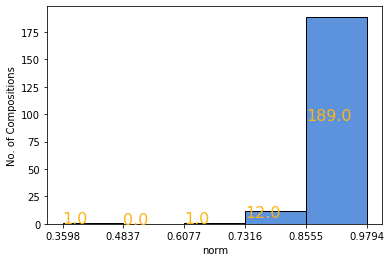

In [15]:
nbins = 5
column = 'norm'
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lit[column], bins = nbins, edgecolor='k', color = "#5d92dd")
ax.set_xticks(bins)
for i in range(len(bins) - 1):
    plt.text(bins[i],counts[i]/2,str(counts[i]), fontsize = 16, color = '#fdb515')
plt.ylabel('No. of Compositions')
plt.xlabel(column)
plt.show()

Alternative. Much simpler - but does not return the bins and the counts.

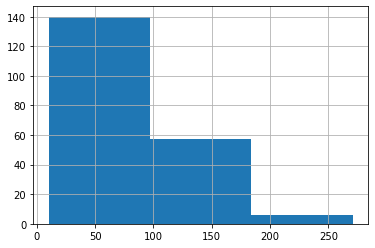

In [16]:
lit.mtld.hist(bins = 3);

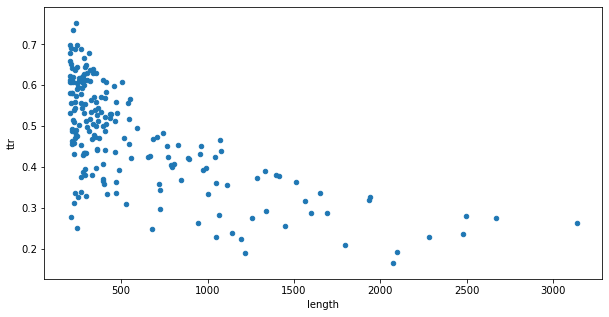

In [19]:
lit.plot.scatter(x = 'length', y = 'ttr', figsize = (10, 5));

# For Creating Output Only
The following code is used to create MarkDown tables from Pandas DataFrames. The tables can be included in the Compass Markdown files.

In [ ]:
from tabulate import tabulate

In [ ]:
etcsl_tab = etcsl_df2.copy()
markdown = "[{}](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text={}&display=Crit&charenc=gcirc#)"
etcsl_tab['id_text'] = [markdown.format(val,val) for val in etcsl_df2['id_text']]
etcsl_tab = etcsl_tab.round({'ttr' : 3, 'norm': 3, 'mtld' : 3})

In [ ]:
rows = 10 # number of rows to be exported
col = 'norm' # column by which to sort
asc = True
tab = tabulate(etcsl_tab.sort_values(by=col, ascending=asc)[:rows],
         headers= etcsl_tab.columns , tablefmt="github", showindex=False)
with open('output/etcsl_tab.txt', 'w', encoding='utf8') as w:
    w.write(tab)

# Testing
Add one word at a time and see how that influences ttr. Does ttr arrive at a plateau?

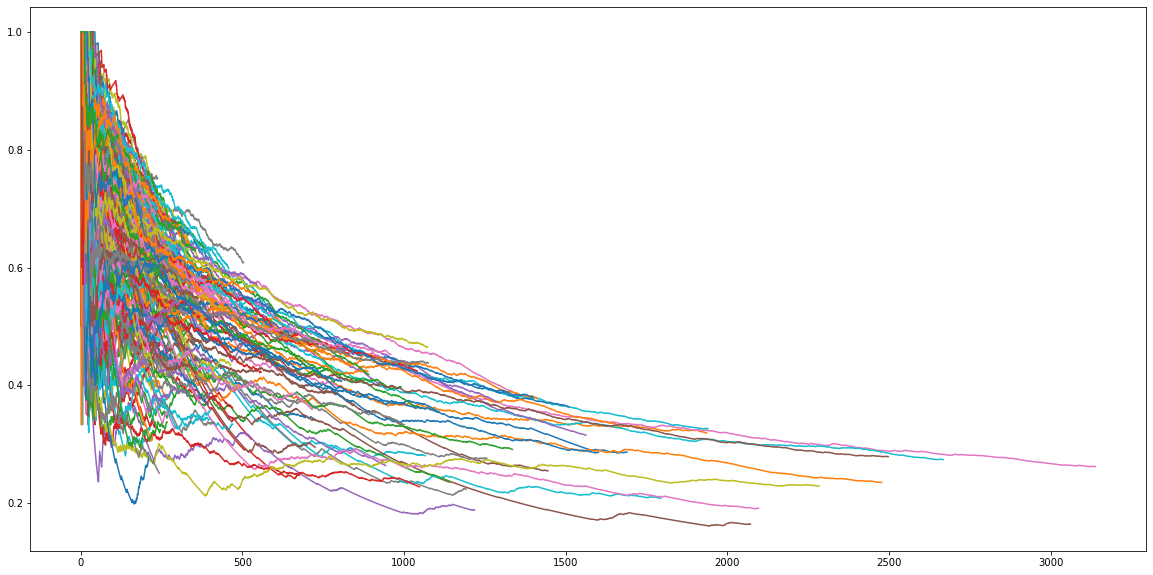

In [46]:
plt.figure(figsize=(20,10))
for id in lit_comp['id_text']:
    c = lit_comp.loc[lit_comp['id_text'] == id, 'lemma_mwe']
    c = c.iloc[0]

    ttr_l = []
    enum = range(1, len(c))
    for ind in enum:
        t = c[:ind]
        ttr = lr(t).ttr
        ttr_l.append(ttr)
    plt.plot(enum, ttr_l)
plt.show()

In [52]:
lit_df2.loc[(86 < lit_df2.mtld) & (lit_df2.mtld < 162.6)].sort_values(by = 'mtld')

,id_text,designation,length,mtld,ttr,lex_var,n_matches,norm
165,Q000750,The temple hymns,2498,86.438542,0.279023,697,570,0.817791
193,Q000802,Proverbs: collection 9,207,87.312560,0.652174,135,121,0.896296
201,Q000825,Proverbs: of unknown provenance,539,87.972272,0.556586,300,280,0.933333
86,Q000407,A praise poem of Šulgi (Šulgi O),517,88.028801,0.470019,243,229,0.942387
17,P346204,ETCSL 1.01.04 Enki’s Journey to Nippur ('Decad...,352,88.609159,0.559659,197,187,0.949239
...,...,...,...,...,...,...,...,...
114,Q000490,A šir-namgala (?) to Inana for Ur-Ninurta (Ur-...,436,151.730389,0.520642,227,211,0.929515
174,Q000767,A dialogue between two unnamed scribes,549,153.614964,0.566485,311,295,0.948553
18,P346209,ETCSL 2.02.03 Lament for Sumer and Ur (witness),335,154.038099,0.629851,211,191,0.905213
34,Q000337,Enlil and Sud,971,154.347421,0.391349,380,342,0.900000


Following needs to be redone with Q numbers

In [47]:
tetrad = {'c.2.5.8.1' : 1, 'c.2.5.3.2' : 1, 'c.2.5.5.2' : 1, 'c.4.16.1': 1}
decad = {'c.2.4.2.01' : 2, 'c.2.5.5.1' : 2, 'c.5.5.4' : 2, 'c.4.07.2' : 2, 'c.4.05.1' : 2,
         'c.4.80.2' : 2, 'c.1.1.4' : 2, 'c.1.3.2' : 2, 'c.4.28.1' : 2, 'c.1.8.1.5' : 2}
houseF = {'c.5.1.2' : 3,'c.5.1.3' : 3, 'c.1.8.1.4' : 3, 'c.1.6.2' : 3, 'c.2.1.5' : 3,
          'c.2.4.2.02' : 3, 'c.2.2.2' : 3, 'c.5.6.1' : 3, 'c.5.1.1' : 3, 'c.5.3.2' : 3,
          'c.1.4.3' : 3, 'c.5.6.3' : 3, 'c.5.4.1' : 3, 'c.5.3.1' : 3}
proverbs = {'c.6.1.01' : 4, 'c.6.1.02' : 4, 'c.6.1.03' : 4, 'c.6.1.04' : 4, 'c.6.1.05' : 4,
            'c.6.1.06' : 4, 'c.6.1.07' : 4,'c.6.1.08' : 4, 'c.6.1.09' : 4, 'c.6.1.10' : 4,
            'c.6.1.11' : 4, 'c.6.1.12' : 4, 'c.6.1.13' : 4, 'c.6.1.14' : 4,'c.6.1.15' : 4,
            'c.6.1.16' : 4, 'c.6.1.17' : 4, 'c.6.1.18' : 4, 'c.6.1.19' : 4, 'c.6.1.20' : 4,
            'c.6.1.21' : 4, 'c.6.1.22' : 4, 'c.6.1.23' : 4, 'c.6.1.24' : 4, 'c.6.1.25' : 4,
            'c.6.1.26' : 4, 'c.6.1.27' : 4, 'c.6.1.28' : 4, 'c.6.2.1' : 4, 'c.6.2.2' : 4,
            'c.6.2.3' : 4,'c.6.2.4' : 4,'c.6.2.5' : 4}

In [53]:
educL = {}
educL.update(tetrad)
educL.update(decad)
educL.update(houseF)
educL.update(proverbs)
educ = lit_df2.loc[lit_df2.id_text.isin(educL)].sort_values(by = 'norm')
educ

,id_text,designation,length,mtld,ttr,lex_var,n_matches,norm


In [ ]:
educ['category'] = [educL[id] for id in educ.id_text]

In [ ]:
educ.sort_values(by = 'mtld')

In [ ]:
etcsl.norm.describe()

In [ ]:
etcsl.loc[round(etcsl.norm, 3) == 0.874].style

In [ ]:
import seaborn as sns
#colors = {1 :'red', 2:'blue', 3:'green', 4:'black'}
#plt.scatter(educ.norm, educ.mtld, s =75, c=educ['category'].apply(lambda x: colors[x]), alpha = 1)
sns.scatterplot('norm', 'mtld', data=educ, hue='category', size = 'length', sizes = (50, 200), alpha = 0.75)

In [ ]:
educL['c.2.5.5.2']

In [ ]:
hymns = etcsl_df2.loc[etcsl_df2.id_text.str.startswith('c.2')]

In [ ]:
hymns.sort_values(by = 'id_text')

In [ ]:
genres = etcsl_df2.groupby(etcsl_df2.id_text.str[:5]).aggregate({'norm' : 'mean'})

In [ ]:
genres.plot()

In [ ]:
etcsl[['mtld', 'length', 'norm', 'lex_var', 'ttr', 'n_matches']].describe()

In [ ]:
DD = set(etcsl_comp.lemma_mwe.iloc[13])

In [ ]:
len(DD - set(lex_vocab))

In [ ]:
len(DD)

In [ ]:
etcsl_comp.iloc[13]

In [ ]:
etcsl_df2.loc[etcsl_df2.id_text == 'c.1.4.3']

In [ ]:
etcsl.norm.median()